In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
calibration_images_filepaths = ["./images/topography/slice_20b.png", "./images/topography/slice_40b.png", "./images/topography/slice_60b.png"]
# calibration_images_filepaths = ["/usercode/images/topography/slice_20b.png", "/usercode/images/topography/slice_40b.png", "/usercode/images/topography/slice_60b.png"]
# Read the calibration images
# They represent the laser line on steps at 20 mm, 40 mm, and 60 mm.
calibration_imgs = [cv2.imread(filepath) for filepath in calibration_images_filepaths]

In [3]:
# Blur the red channel of each image, with a blurring kernel od size (5, 5)
blur_size = (5, 5)
blurred_slice_20_img = cv2.blur(calibration_imgs[0][:, :, 2], blur_size)
blurred_slice_40_img = cv2.blur(calibration_imgs[1][:, :, 2], blur_size)
blurred_slice_60_img = cv2.blur(calibration_imgs[2][:, :, 2], blur_size)

In [4]:
# For each x, identify the y where the red intensity is maximum. Store y_max in three dictionaries.
# If the maximum intensity is below the threshold, store -1 instead.
minimum_red_value = 10
slice_img_sizeHW = blurred_slice_20_img.shape
x_to_ymax_20 = {}
x_to_ymax_40 = {}
x_to_ymax_60 = {}
for x in range(slice_img_sizeHW[1]):
    # Extract a single column of each blurred image
    column_20_img = blurred_slice_20_img[:, x]
    column_40_img = blurred_slice_40_img[:, x]
    column_60_img = blurred_slice_60_img[:, x]
    _, max_val_20, _, max_loc_20 = cv2.minMaxLoc(column_20_img)
    _, max_val_40, _, max_loc_40 = cv2.minMaxLoc(column_40_img)
    _, max_val_60, _, max_loc_60 = cv2.minMaxLoc(column_60_img)
    if max_val_20 > minimum_red_value:
        x_to_ymax_20[x] = max_loc_20[1]  # We keep the y value
    else:
        x_to_ymax_20[x] = -1  # Flag to indicate that the signal is too weak
    if max_val_40 > minimum_red_value:
        x_to_ymax_40[x] = max_loc_40[1]  # We keep the y value
    else:
        x_to_ymax_40[x] = -1  # Flag to indicate that the signal is too weak
    if max_val_60 > minimum_red_value:
        x_to_ymax_60[x] = max_loc_60[1]  # We keep the y value
    else:
        x_to_ymax_60[x] = -1  # Flag to indicate that the signal is too weak

In [5]:
# For each x, fit a line that best satisfies the three points (y_max, Y) where Y is the height in mm
x_to_a_b = {}
for x in range(slice_img_sizeHW[1]):
    if x_to_ymax_20[x] >= 0 and x_to_ymax_40[x] >= 0 and x_to_ymax_60[x] >= 0:
        p0 = (x_to_ymax_20[x], 20.0)
        p1 = (x_to_ymax_40[x], 40.0)
        p2 = (x_to_ymax_60[x], 60.0)
        # Solve an overdetermined system of linear equations:
        #      A x = b
        # | x_0   1 | | a |   | y_0 |
        # | x_1   1 | | b | = | y_1 |
        # | x_2   1 |         | y_2 |
        A = np.ones((3, 2), dtype=float)
        b = np.zeros((3, 1), dtype=float)
        A[0, 0] = p0[0]
        A[1, 0] = p1[0]
        A[2, 0] = p2[0]
        b[0, 0] = p0[1]
        b[1, 0] = p1[1]
        b[2, 0] = p2[1]
        ab, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        a = ab[0, 0]
        b = ab[1, 0]
        x_to_a_b[x] = (a, b)
    else:
        x_to_a_b[x] = (None, None)


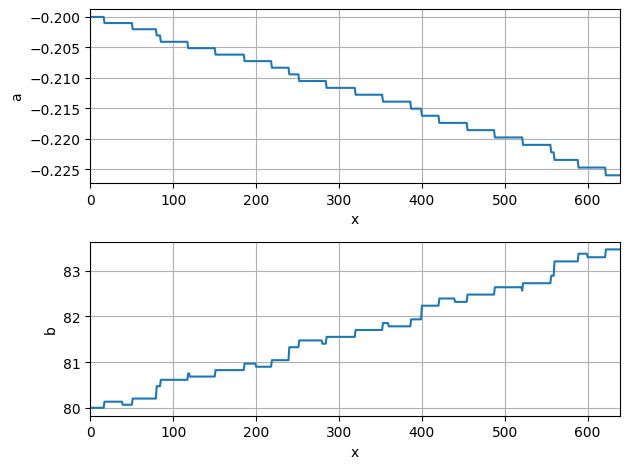

In [6]:
# Plot the a, b parameters
x_list = list(range(slice_img_sizeHW[1]))
a_list = [x_to_a_b[x][0] for x in x_list]
b_list = [x_to_a_b[x][1] for x in x_list]
fig, axs = plt.subplots(2, 1)
axs[0].plot(x_list, a_list)
axs[0].set_xlim(0, slice_img_sizeHW[1] - 1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('a')
axs[0].grid(True)
axs[1].plot(x_list, b_list)
axs[1].set_xlim(0, slice_img_sizeHW[1] - 1)
axs[1].set_xlabel('x')
axs[1].set_ylabel('b')
axs[1].grid(True)
fig.tight_layout()
plt.show()

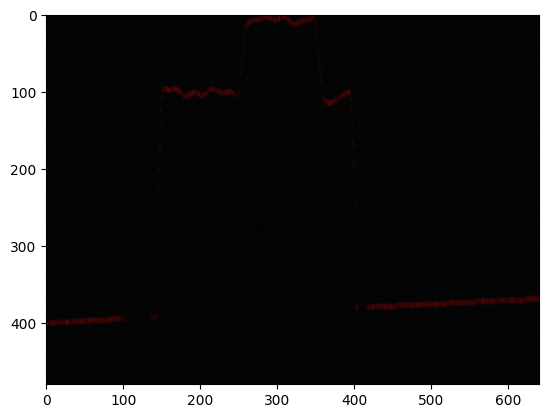

In [7]:
# Receive a slice image
#slice_img = slice_generator.get_image(450, x_to_a_b)  # slice_generator.get_image is a black box acquisition system
#cv2.imwrite("./generated_slice.png", slice_img)
slice_img = cv2.imread("/home/sebastien/Documents/Programmation/educative/AutomatedInspectionWithCV/images/topography/grabbed_object_slice.jpg")
#slice_img = cv2.imread("/usercode/images/topography/grabbed_object_slice.png")
plt.imshow(cv2.cvtColor(slice_img, cv2.COLOR_BGR2RGB))


In [8]:
# Convert the slice image into a topographic slice<
# Blur the red channel
blurred_slice_img = cv2.blur(slice_img[:, :, 2], blur_size)
heights = []
for x in range(blurred_slice_img.shape[1]):
    _, max_val, _, max_loc = cv2.minMaxLoc(blurred_slice_img[:, x])  # We look at a single column of pixels
    if max_val >= minimum_red_value:
        y = max_loc[1]  # (0, y_max)
        a = x_to_a_b[x][0]
        b = x_to_a_b[x][1]
        heights.append(a * y + b)
    else:
        heights.append(-1)  # Special flag for 'unknown'

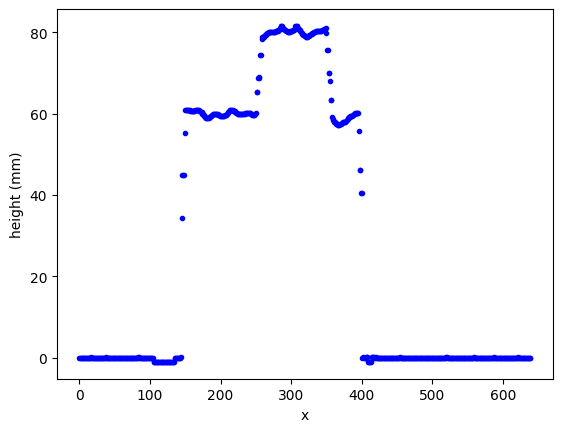

In [9]:
# Display the topographic slice
xs = np.arange(0, len(heights))
fig, ax = plt.subplots()
ax.scatter(xs, heights, c="blue", marker='.')
ax.set_xlabel('x')
ax.set_ylabel('height (mm)')
plt.show()